In [36]:
# python packages pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import inspect

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional, Activation
from keras.layers import CuDNNLSTM
from keras.utils.np_utils import to_categorical
# from keras.callbacks import EarlyStopping
from keras.layers import Dropout

from sklearn.model_selection import train_test_split
import importlib
import utilis

# custom
from keras import backend as K
from keras.layers import Layer
from keras.constraints import MinMaxNorm
from keras import initializers, regularizers, constraints, Input
from keras.models import Model

In [2]:
sys.path.append("..")

In [3]:
# custom python scripts
from packages import generator

In [4]:
importlib.reload(generator)

<module 'packages.generator' from '../packages/generator.py'>

In [5]:
# # check version
# print(inspect.getsource(generator.Keras_DataGenerator))

# Bidirectional LSTM with Hypotheses

In [6]:
# Check that you are running GPU's
utilis.GPU_checker()





You are runnning an instance with 4 GPU's


In [7]:
utilis.aws_setup()

AWS SETUP SHOULD BE COMPLETE, we are on <botocore.client.S3 object at 0x7f62b847a940>


# Config, generators and train

In [8]:
INPUT_TENSOR_NAME = "inputs_input"
SIGNATURE_NAME = "serving_default"
W_HYP = True
LEARNING_RATE = 0.001
BATCH_SIZE = 64

# constnats
VOCAB_SIZE = 1254
INPUT_LENGTH = 3000 if W_HYP else 1000
EMBEDDING_DIM = 512

print(INPUT_LENGTH)

3000


In [9]:
importlib.reload(generator)

# generators
training_generator = generator.Keras_DataGenerator(data_dir='', subset_frac=0.04,  dataset='train_new', w_hyp=W_HYP)
print()
validation_generator = generator.Keras_DataGenerator(data_dir='', subset_frac=0.04, dataset='valid_new', w_hyp=W_HYP)

# of batches:  5888.0
# of batches reduced to:  235.52
Generating examples from a set of 15073.28 examples 


# of batches:  1600.0
# of batches reduced to:  64.0
Generating examples from a set of 4096.0 examples 



In [40]:
# custom dot product function
def dot_product(x, kernel):
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    
# find a way to return attention weight vector a
class AttentionWithContext(Layer):
    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        # initialization of all learnable params
        self.init = initializers.get('glorot_uniform')
        
        # regularizers for params, init as None
        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        
        # constraints for params, init as None
        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
#         assert len(input_shape) == 3
        
        # weight matrix
        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        # bias term
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='lecun_uniform',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        
        # context vector
        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)
        
    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)
        
        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
#         a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon() * 100, K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]  

    
# model
def build_model(vocab_size, embedding_dim, input_length):
    sequence_input = Input(shape=(input_length,), dtype='int32')
    embedded_sequences = Embedding(vocab_size, embedding_dim, input_length=input_length)(sequence_input)
    output_1 = SpatialDropout1D(0.2)(embedded_sequences)
    output_2 = Bidirectional(CuDNNLSTM(512, return_sequences=True, 
                                       kernel_constraint=MinMaxNorm(min_value=0.0001, max_value=1.0, rate=1.0, axis=0), 
                                       recurrent_constraint=MinMaxNorm(min_value=0.0001, max_value=1.0, rate=1.0, axis=0), 
                                       bias_constraint = MinMaxNorm(min_value=0.0001, max_value=1.0, rate=1.0, axis=0)))(output_1)
    context_vec = AttentionWithContext(
        W_constraint = MinMaxNorm(min_value=0.0001, max_value=1.0, rate=1.0, axis=0),
        u_constraint = MinMaxNorm(min_value=0.0001, max_value=1.0, rate=1.0, axis=0),
        b_constraint = MinMaxNorm(min_value=0.0001, max_value=1.0, rate=1.0, axis=0))(output_2)
    predictions = Dense(41, kernel_constraint = MinMaxNorm(min_value=0.0001, max_value=1.0, rate=1.0, axis=0), activation='softmax')(context_vec)
    model = Model(inputs=sequence_input, outputs=predictions)
    return model

### testing generator

In [41]:
model = build_model(VOCAB_SIZE, EMBEDDING_DIM, INPUT_LENGTH)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 3000)              0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 3000, 512)         642048    
_________________________________________________________________
spatial_dropout1d_10 (Spatia (None, 3000, 512)         0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 3000, 1024)        4202496   
_________________________________________________________________
attention_with_context_10 (A (None, 1024)              1050624   
_________________________________________________________________
dense_8 (Dense)              (None, 41)                42025     
Total params: 5,937,193
Trainable params: 5,937,193
Non-trainable params: 0
_________________________________________________________________


In [42]:
## ARE YOU LOADING A MODEL IF YES RUN TEH FOLLOWING LINES 
# from keras.models import model_from_json
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")
# # REMEMEBER TO COMPILE 
# loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [43]:
#overwriting model
# model = loaded_model

In [55]:
model.layers[4].get_weights()

[array([[-0.0439272 ,  0.0066037 ,  0.03886869, ..., -0.04373638,
          0.04266287,  0.04329046],
        [-0.02320955, -0.04116483, -0.03143328, ..., -0.00882623,
          0.01544392, -0.01263598],
        [ 0.04643551,  0.0510483 , -0.01836326, ...,  0.01667132,
          0.01476378, -0.01697918],
        ...,
        [ 0.05962684, -0.00668043, -0.02241782, ...,  0.02251086,
         -0.01755485, -0.03494317],
        [-0.03065338,  0.06196434,  0.05576675, ...,  0.03866867,
          0.09476715,  0.06058833],
        [-0.00992898,  0.00655972, -0.00045285, ..., -0.02361523,
          0.04554807, -0.0028964 ]], dtype=float32),
 array([ 0.07597582,  0.02732145, -0.02807521, ..., -0.02794006,
         0.04279055,  0.02922837], dtype=float32),
 array([-0.04136521, -0.03058277,  0.02706152, ...,  0.03879815,
        -0.0331724 , -0.03668458], dtype=float32)]

In [63]:
%%time
#try and make it run until 9 am GMT+1
n_epochs = 8
history = model.fit_generator(generator=training_generator,
                            validation_data=validation_generator,
                            verbose=1,
                            use_multiprocessing=True,
                            epochs=n_epochs)

Epoch 1/8
 56/235 [======>.......................] - ETA: 7:13 - loss: 1.8225 - acc: 0.3861

Process ForkPoolWorker-62:
Process ForkPoolWorker-63:


KeyboardInterrupt: 

Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6

## Save modek

In [52]:
# FOR SAVING MODEL
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [49]:
#WARNING_DECIDE_HOW_TO_NAME_LOG
#descriptionofmodel_personwhostartsrun
#e.g. LSTM_128encoder_etc_tanc
LOSS_FILE_NAME = "forjeff3"

#WARNING NUMBER 2 - CURRENTLY EVERYTIME YOU RERUN THE CELLS BELOW THE FILES WITH THOSE NAMES GET WRITTEN OVER

In [50]:
# save history - WARNING FILE NAME 
utilis.history_saver_bad(history, LOSS_FILE_NAME)

SAVED SOME LOGS -- OVERWROTE OLD LOGS -- SOMEONE NEEDS TO FIX THIS


In [53]:
Epoch 1/8
235/235 [==============================] - 633s 3s/step - loss: 2.5071 - acc: 0.2366 - val_loss: 2.2807 - val_acc: 0.2778
Epoch 2/8
235/235 [==============================] - 596s 3s/step - loss: 2.2096 - acc: 0.2912 - val_loss: 2.2231 - val_acc: 0.2837
Epoch 3/8
235/235 [==============================] - 599s 3s/step - loss: 2.1271 - acc: 0.3055 - val_loss: 2.1742 - val_acc: 0.2817
Epoch 4/8
235/235 [==============================] - 601s 3s/step - loss: 2.0601 - acc: 0.3216 - val_loss: 2.1557 - val_acc: 0.2869
Epoch 5/8
235/235 [==============================] - 582s 2s/step - loss: 1.9939 - acc: 0.3343 - val_loss: 2.0946 - val_acc: 0.3145
Epoch 6/8
235/235 [==============================] - 590s 3s/step - loss: 1.9377 - acc: 0.3496 - val_loss: 2.0405 - val_acc: 0.3240
Epoch 7/8
235/235 [==============================] - 602s 3s/step - loss: 1.8974 - acc: 0.3590 - val_loss: 2.0558 - val_acc: 0.3206
Epoch 8/8
235/235 [==============================] - 607s 3s/step - loss: 2.3994 - acc: 0.2478 - val_loss: 2.4301 - val_acc: 0.2576
CPU times: user 20min 56s, sys: 6min 13s, total: 27min 9s
Wall time: 1h 20min 10s
Epoch 1/8
235/235 [==============================] - 623s 3s/step - loss: 2.3551 - acc: 0.2728 - val_loss: 2.3344 - val_acc: 0.2639
Epoch 2/8
235/235 [==============================] - 598s 3s/step - loss: 2.2601 - acc: 0.2972 - val_loss: 2.2669 - val_acc: 0.2881
Epoch 3/8
235/235 [==============================] - 598s 3s/step - loss: 2.0409 - acc: 0.3342 - val_loss: 2.0943 - val_acc: 0.3230
Epoch 4/8
235/235 [==============================] - 598s 3s/step - loss: 1.9858 - acc: 0.3426 - val_loss: 2.1001 - val_acc: 0.3115
Epoch 5/8
235/235 [==============================] - 596s 3s/step - loss: 1.9489 - acc: 0.3591 - val_loss: 2.0977 - val_acc: 0.3164
Epoch 6/8
235/235 [==============================] - 592s 3s/step - loss: 1.9035 - acc: 0.3658 - val_loss: 2.0781 - val_acc: 0.3193
Epoch 7/8
235/235 [==============================] - 594s 3s/step - loss: 1.8696 - acc: 0.3728 - val_loss: 2.0858 - val_acc: 0.3237
Epoch 8/8
235/235 [==============================] - 598s 3s/step - loss: 1.8482 - acc: 0.3827 - val_loss: 2.1564 - val_acc: 0.2913
CPU times: user 20min 57s, sys: 6min 18s, total: 27min 16s
Wall time: 1h 19min 57s

SyntaxError: invalid syntax (<ipython-input-53-a5c289edbd9e>, line 1)

In [61]:
test_generator = generator.Keras_DataGenerator(data_dir='', subset_frac=0.01,  dataset='test_new', w_hyp=W_HYP)


# of batches:  1920.0
# of batches reduced to:  19.2
Generating examples from a set of 1228.8 examples 



In [ ]:
model.evaluate_generator(test_generator, verbose =1)

76/76 [==============================] - 152s 2s/step


[2.0996550007870325, 0.31085526315789475]

In [66]:
scores = model.predict_generator(test_generator)

In [69]:
scores.shape

(1216, 41)

In [80]:
medians = np.mean(scores, axis = 0)

In [79]:
# that is incorrect you 

(41,)

In [81]:
import matplotlib.pyplot as plt

(array([18.,  6.,  1.,  1.,  2.,  2.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,
         0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,
         0.,  1.]),
 array([4.8479786e-05, 3.6590956e-03, 7.2697117e-03, 1.0880328e-02,
        1.4490943e-02, 1.8101560e-02, 2.1712175e-02, 2.5322791e-02,
        2.8933408e-02, 3.2544024e-02, 3.6154639e-02, 3.9765254e-02,
        4.3375872e-02, 4.6986487e-02, 5.0597101e-02, 5.4207720e-02,
        5.7818335e-02, 6.1428949e-02, 6.5039568e-02, 6.8650179e-02,
        7.2260797e-02, 7.5871415e-02, 7.9482026e-02, 8.3092645e-02,
        8.6703263e-02, 9.0313874e-02, 9.3924493e-02, 9.7535111e-02,
        1.0114572e-01, 1.0475634e-01, 1.0836696e-01, 1.1197757e-01,
        1.1558819e-01, 1.1919881e-01, 1.2280942e-01, 1.2642004e-01,
        1.3003065e-01, 1.3364127e-01, 1.3725188e-01, 1.4086249e-01,
        1.4447312e-01, 1.4808373e-01], dtype=float32),
 <a list of 41 Patch objec

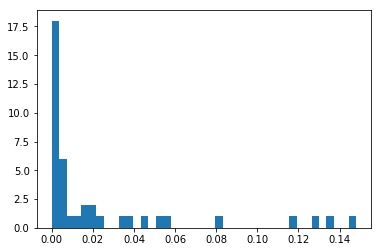

In [83]:
plt.hist(medians, bins = 41, )

In [84]:
medians

array([2.3056319e-02, 7.3947106e-04, 1.6482010e-02, 1.3393353e-01,
       6.5598404e-03, 1.1678290e-01, 4.8479786e-05, 6.3458993e-03,
       8.1192203e-02, 3.2560644e-04, 1.2302495e-02, 4.8625403e-05,
       1.1585184e-03, 5.5935886e-02, 4.9044331e-05, 1.4808373e-01,
       5.0649893e-02, 2.0177178e-04, 2.0632645e-04, 1.6963262e-03,
       4.8585280e-05, 6.2902825e-04, 4.6379559e-02, 3.2427732e-04,
       3.7667744e-02, 7.6628197e-04, 2.1278964e-02, 5.1423348e-03,
       3.3325974e-02, 2.2866658e-03, 4.9360158e-05, 1.7087765e-02,
       2.0177618e-02, 5.9537329e-03, 8.3101830e-03, 1.7738924e-03,
       1.0386455e-03, 1.2937297e-01, 4.8508402e-03, 6.2436252e-03,
       1.4930550e-03], dtype=float32)

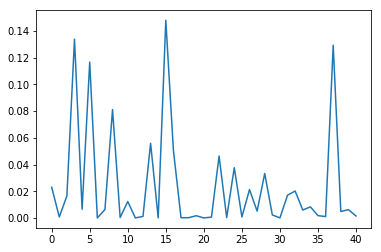

In [86]:
plt.plot(medians)
lis  = [x for x in range(1,42)]

Text(0.5, 1.0, 'Distribution of Labels - Attention G&H')

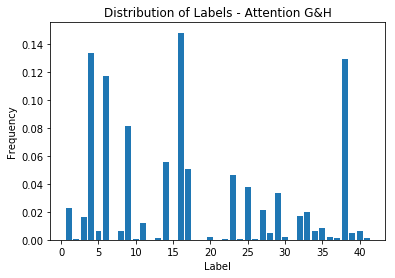

In [87]:
plt.bar(lis, medians)
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.title("Distribution of Labels - Attention G&H")